# Informe Proyecto Final
### Presentado a: John Fredy Ochoa y Diana Carolina Arboleda
### Presentado por: Alejadro Escobar y Jose Fernando Chilito 

En el presente informe se abarcará el análisi exploratorio de datos trabajando con el archivo obtenido en el código de Python Proyecto3_Final.py. Esta determinación se tomó debido a la extension de codigo y de procesamiento que se requría en dicha rutina. 
En el presente trabajo se explicará cómo se obtienen y categorizan los datos crudos para su posterior análisis. Se encuentras además una serie de datos que permiten analizar lo que sucede con los pacientes del estudio, se observarán las pruebas de hipótesis realizadas. 

In [64]:
#%% Librerias
import math
import librosa
import librosa.display
import numpy as np
import pandas as pd
import scipy.signal as signal
from linearFIR import filter_design
from Filtrado_Wavelet import filtrado
from os import listdir
from os.path import isfile, join
from IPython import get_ipython
from scipy.stats import ttest_ind, mannwhitneyu
import seaborn as sns #Graficacion
import matplotlib.pyplot as plt #Graficacion

## Creación del DataFrame

A continuación se carga el data frame con el que se va a trabajar, el cual contiene el nombre de los archivos, los ciclos, si el paciente no presenta patologías, presente crepitancias, sibilancias, además valores como varianza, rango de tiempo, la suma de los promedios y el promedio del espectro de potencia. 

In [8]:
datos=pd.read_csv('Datos_estudio.csv',header=0,sep=',',decimal=".");

Con el siguiente comando se muestran los primeros datos del Data Frame

In [53]:
datos.head()

,Unnamed: 0,Unnamed: 1,Ciclo Respiratorio,Normal,Crepitancia,Sibilancia,Varianza,Rango,Suma de Promedios,Promedio de Espectros
0,101_1b1_Al_sc_Meditron.wav,0,1.0,1,0.0,0.0,0.000126,0.149517,7.251985e-07,0.000251
1,101_1b1_Al_sc_Meditron.wav,1,2.0,1,0.0,0.0,0.000134,0.170549,-2.137991e-07,0.000269
2,101_1b1_Al_sc_Meditron.wav,2,3.0,1,0.0,0.0,0.000130,0.179019,5.655318e-07,0.000261
3,101_1b1_Al_sc_Meditron.wav,3,4.0,1,0.0,0.0,0.000156,0.216310,7.511071e-07,0.000312
4,101_1b1_Al_sc_Meditron.wav,4,5.0,1,0.0,0.0,0.000104,0.166396,-1.534975e-06,0.000208


### Separación de sujetos
A continuación se crea una rutina que permita separar los archivos en diferentes categorías, están los paciente Sin patologías, con crepitancias, sibilancias y ambas. 

In [10]:
#Se crean 4 dataframes con las mismas columnas del dataframe datos (uno por cada tipo de sujeto)
#el dataframe llamado "normal" gurdará la información de los sujetos sin patología
#el dataframe llamado "sibilanciq" gurdará la información de los sujetos con sibilancia
#el dataframe llamado "crepitancia" gurdará la información de los sujetos con crepitancia
#el dataframe llamado "dobles" gurdará la información de los sujetos con doble patología

normal=pd.DataFrame(columns=datos.columns)
sibilancia=normal
crepitancia=normal
dobles=normal

In [11]:
#En este ciclo se llenan cada uno de los dataframe si cumplen las condiciones determinadas por cada sujeto

for i in range(0,datos.shape[0]):
    if int(datos.at[i,'Normal'])==1:
        normal=normal.append(datos.loc[i])
    elif (int(datos.at[i,'Crepitancia'])==1 and int(datos.at[i,'Sibilancia'])==1):
        dobles=dobles.append(datos.loc[i])
    elif (int(datos.at[i,'Crepitancia'])==0 and int(datos.at[i,'Sibilancia'])==1):
        sibilancia=sibilancia.append(datos.loc[i])
    elif (int(datos.at[i,'Crepitancia'])==1 and int(datos.at[i,'Sibilancia'])==0):
        crepitancia=crepitancia.append(datos.loc[i])

#### Datos descriptivos de los datos

In [12]:
datos.describe()

,Unnamed: 1,Ciclo Respiratorio,Normal,Crepitancia,Sibilancia,Varianza,Rango,Suma de Promedios,Promedio de Espectros
count,6898.000000,6898.000000,6898.000000,6898.000000,6898.000000,6.898000e+03,6898.000000,6.898000e+03,6.898000e+03
mean,3.990142,4.990142,0.527979,0.343578,0.201798,2.400564e-03,0.520964,8.374261e-08,4.800983e-03
std,3.682312,3.682312,0.499253,0.474937,0.401371,5.710398e-03,0.533683,6.045344e-06,1.142047e-02
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.654615e-07,0.003074,-1.025104e-04,3.308810e-07
25%,1.000000,2.000000,0.000000,0.000000,0.000000,7.976998e-05,0.128388,-8.246437e-07,1.595379e-04
50%,3.000000,4.000000,1.000000,0.000000,0.000000,5.121308e-04,0.327044,1.730934e-09,1.024207e-03
75%,6.000000,7.000000,1.000000,1.000000,0.000000,2.192283e-03,0.723228,8.394734e-07,4.384490e-03
max,32.000000,33.000000,1.000000,1.000000,1.000000,1.312930e-01,3.168455,1.427491e-04,2.625818e-01


In [13]:
normal.describe()

,Ciclo Respiratorio,Crepitancia,Sibilancia,Varianza,Rango,Suma de Promedios,Promedio de Espectros
count,3642.000000,3642.0,3642.0,3.642000e+03,3642.000000,3.642000e+03,3.642000e+03
mean,5.334706,0.0,0.0,1.760379e-03,0.435239,4.773215e-09,3.520645e-03
std,4.051678,0.0,0.0,3.988576e-03,0.498664,6.084114e-06,7.976888e-03
min,1.000000,0.0,0.0,1.654615e-07,0.003074,-1.025104e-04,3.308810e-07
25%,2.000000,0.0,0.0,4.770419e-05,0.089055,-6.791630e-07,9.540597e-05
50%,5.000000,0.0,0.0,2.706090e-04,0.235538,-1.024582e-08,5.411960e-04
75%,7.000000,0.0,0.0,1.503748e-03,0.586645,6.320124e-07,3.007439e-03
max,33.000000,0.0,0.0,4.831958e-02,3.064614,1.427491e-04,9.663078e-02


In [14]:
crepitancia.describe()

,Ciclo Respiratorio,Crepitancia,Sibilancia,Varianza,Rango,Suma de Promedios,Promedio de Espectros
count,1864.000000,1864.0,1864.0,1.864000e+03,1864.000000,1.864000e+03,1.864000e+03
mean,4.627146,1.0,0.0,2.304791e-03,0.607804,1.807526e-07,4.609451e-03
std,3.277296,0.0,0.0,4.362631e-03,0.519653,5.570299e-06,8.725000e-03
min,1.000000,1.0,0.0,1.878902e-07,0.004617,-6.733085e-05,3.757734e-07
25%,2.000000,1.0,0.0,1.786638e-04,0.210889,-1.037540e-06,3.573080e-04
50%,4.000000,1.0,0.0,7.597550e-04,0.447891,8.365171e-09,1.519474e-03
75%,6.000000,1.0,0.0,2.609942e-03,0.847974,1.229093e-06,5.219718e-03
max,30.000000,1.0,0.0,6.639070e-02,2.741568,7.922186e-05,1.327772e-01


In [15]:
sibilancia.describe()

,Ciclo Respiratorio,Crepitancia,Sibilancia,Varianza,Rango,Suma de Promedios,Promedio de Espectros
count,886.000000,886.0,886.0,8.860000e+02,886.000000,8.860000e+02,8.860000e+02
mean,4.668172,0.0,1.0,4.524378e-03,0.614348,2.138923e-07,9.048484e-03
std,3.071363,0.0,0.0,1.063272e-02,0.609702,6.665810e-06,2.126487e-02
min,1.000000,0.0,1.0,4.722855e-07,0.007317,-3.813499e-05,9.445616e-07
25%,2.000000,0.0,1.0,1.427079e-04,0.170493,-7.893244e-07,2.854037e-04
50%,4.000000,0.0,1.0,9.226102e-04,0.383206,3.419309e-08,1.845188e-03
75%,6.000000,0.0,1.0,3.842057e-03,0.848348,8.989234e-07,7.683729e-03
max,18.000000,0.0,1.0,1.312930e-01,3.168455,1.007249e-04,2.625818e-01


In [16]:
dobles.describe()

,Ciclo Respiratorio,Crepitancia,Sibilancia,Varianza,Rango,Suma de Promedios,Promedio de Espectros
count,506.000000,506.0,506.0,5.060000e+02,506.000000,5.060000e+02,5.060000e+02
mean,4.411067,1.0,1.0,3.642412e-03,0.654573,6.687960e-08,7.284623e-03
std,2.968647,0.0,0.0,7.061344e-03,0.579080,6.308552e-06,1.412230e-02
min,1.000000,1.0,1.0,4.422157e-07,0.007291,-7.795340e-05,8.844190e-07
25%,2.000000,1.0,1.0,1.924752e-04,0.204473,-1.154877e-06,3.849437e-04
50%,4.000000,1.0,1.0,9.621824e-04,0.432711,2.781430e-08,1.924346e-03
75%,6.000000,1.0,1.0,3.915298e-03,1.013185,1.028870e-06,7.830325e-03
max,18.000000,1.0,1.0,8.048232e-02,2.818772,5.423571e-05,1.609621e-01


## Gráficos

### Pie

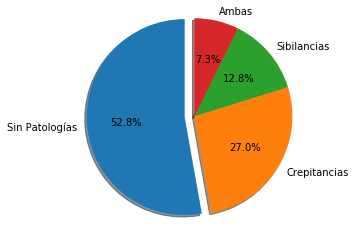

In [52]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Sin Patologías', 'Crepitancias', 'Sibilancias', 'Ambas'
sizes = [3642, 1864, 886, 506]
explode = (0.1, 0, 0, 0)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


El presente gráfico nos permite conocer el porcentaje de ciclos que pertenecen a las cuatro categorías, se puede observar que la mayor cantidad de pacientes no presenta patologías, seguida por las creitancias, luego las sibilancias y en un menor porcentaje quienes presentan ambas. Una mayoría simple de ciclos no presenta patologías, sin embargo dentro de las patologías las crepitancias representan más de la mitad de las muestras, por lo tanto es la patología con más incidencia dentro del estudio. 

### Box Plot

En esta sección se organizaron los gráficos por cada categorías y se graficas las cuatro variables en cada uno de ellas. 
###### Debido a problemas con el tamaño de la imagen no se visualiza muy bien el label en la primera imagen pero hace referencia a Varianza y Promedio de Espectro, respectivamente.

[]

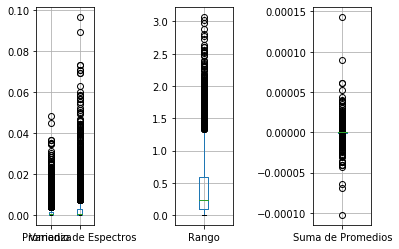

In [61]:
#Gráfico de cajas y bigotes para pacientes sin patologías
plt.subplot(1,5,1)
normal.boxplot(column=['Varianza','Promedio de Espectros'])
plt.plot()
plt.subplot(1,5,3)
normal.boxplot(column=['Rango'])
plt.plot()
plt.subplot(1,5,5)
normal.boxplot(column=['Suma de Promedios'])
plt.plot()

[]

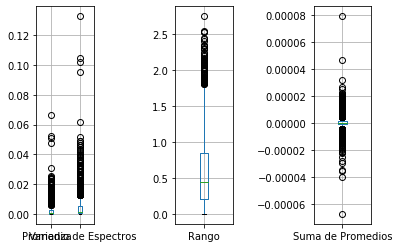

In [55]:
#Gráfico de cajas y bigotes para pacientes con crepitancias

plt.subplot(1,5,1)
crepitancia.boxplot(column=['Varianza','Promedio de Espectros'])
plt.plot()
plt.subplot(1,5,3)
crepitancia.boxplot(column=['Rango'])
plt.plot()
plt.subplot(1,5,5)
crepitancia.boxplot(column=['Suma de Promedios'])
plt.plot()

[]

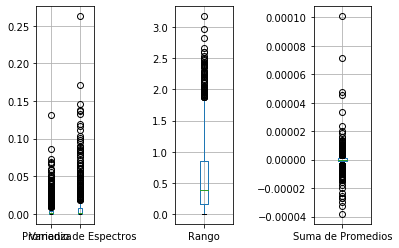

In [54]:
#Gráfico de cajas y bigotes para pacientes con sibilancias

plt.subplot(1,5,1)
sibilancia.boxplot(column=['Varianza','Promedio de Espectros'])
plt.plot()
plt.subplot(1,5,3)
sibilancia.boxplot(column=['Rango'])
plt.plot()
plt.subplot(1,5,5)
sibilancia.boxplot(column=['Suma de Promedios'])
plt.plot()

[]

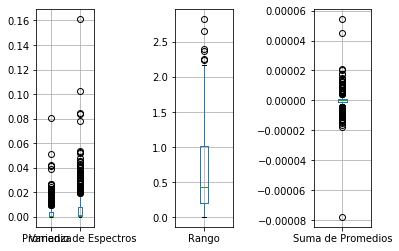

In [59]:
#Gráfico de cajas y bigotes para pacientes con ambas patologias

plt.subplot(1,5,1)
dobles.boxplot(column=['Varianza','Promedio de Espectros'])
plt.plot()
plt.subplot(1,5,3)
dobles.boxplot(column=['Rango'])
plt.plot()
plt.subplot(1,5,5)
dobles.boxplot(column=['Suma de Promedios'])
plt.plot()


Se puede observar que todas las gráficas presentan una candtidad bastante grande de valores atípicos, estos valores atípicos se pueden deber a varias cosas, la primera puede ser el filtrado de wavelet que puede ser inexacto y ocasionar estos valores atipicos, la otra podría ser a la toma de las muestras, como se sabía las muestras venías muy contaminadas, en los audios se escuchaban voces de fondo y sonidos del exterior que a la hora de realizar el filtrado o persistian o modificaban los valores que debía ser normales. 

### Correlación

A continuación se encuentra el gráfico de la correlación entre todos los parámetros de todas las categorías 

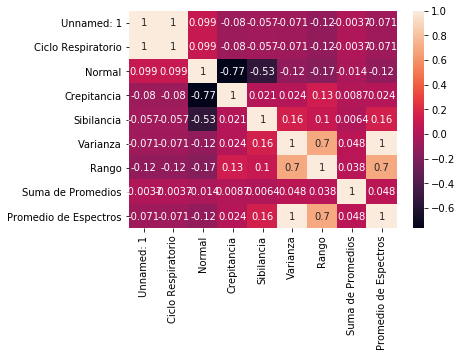

In [29]:
correlation=datos.corr()
sns.heatmap(correlation, annot=True)
plt.show()

No existe una correlación en general entre los parámetros, los únicos que podrían tener relación alguna son el rango con la varianza, y en un caso muy particular el promedio del espectro con la varianza, los valores no son los mismos como se puede observar en los dataframe, pero sus valores son tan pequeños que al hacer la comparación cualquier variación no es tomada en cuenta y por lo tanto aparece una correlación de 1. 

## Histogramas

En las siguientes gráficas se aprecian los histogramas para cada parámetros en todas las categorias, esto se relizó para determinar de los parámetros seguían una distribución normal.

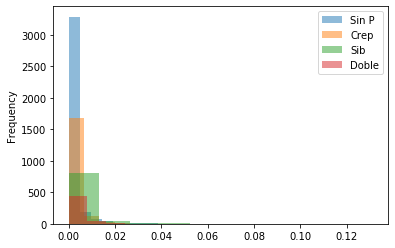

In [45]:
#Histogramas de la Varianza para cada uno de las categorías 
count,bin_edges = np.histogram(normal['Varianza']) 
normal['Varianza'].plot.hist(bins=bin_edges, alpha=0.5) 

count,bin_edges = np.histogram(crepitancia['Varianza']) 
crepitancia['Varianza'].plot.hist(bins=bin_edges, alpha=0.5) 

count,bin_edges = np.histogram(sibilancia['Varianza']) 
sibilancia['Varianza'].plot.hist(bins=bin_edges, alpha=0.5) 

count,bin_edges = np.histogram(dobles['Varianza']) 
dobles['Varianza'].plot.hist(bins=bin_edges, alpha=0.5) 

plt.legend(['Sin P', 'Crep', 'Sib', 'Doble'])

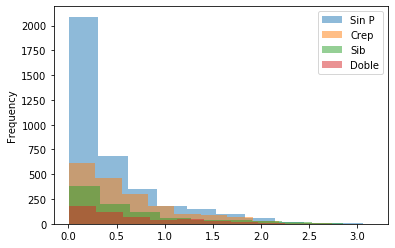

In [47]:
#Histogramas del Rango para cada uno de las categorías 

count,bin_edges = np.histogram(normal['Rango']) 
normal['Rango'].plot.hist(bins=bin_edges, alpha=0.5) 

count,bin_edges = np.histogram(crepitancia['Rango']) 
crepitancia['Rango'].plot.hist(bins=bin_edges, alpha=0.5) 

count,bin_edges = np.histogram(sibilancia['Rango']) 
sibilancia['Rango'].plot.hist(bins=bin_edges, alpha=0.5) 

count,bin_edges = np.histogram(dobles['Rango']) 
dobles['Rango'].plot.hist(bins=bin_edges, alpha=0.5) 

plt.legend(['Sin P', 'Crep', 'Sib', 'Doble'])

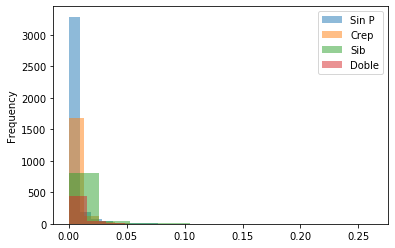

In [48]:
#Histogramas del Promedio de Espectro para cada uno de las categorías 

count,bin_edges = np.histogram(normal['Promedio de Espectros']) 
normal['Promedio de Espectros'].plot.hist(bins=bin_edges, alpha=0.5) 

count,bin_edges = np.histogram(crepitancia['Promedio de Espectros']) 
crepitancia['Promedio de Espectros'].plot.hist(bins=bin_edges, alpha=0.5) 

count,bin_edges = np.histogram(sibilancia['Promedio de Espectros']) 
sibilancia['Promedio de Espectros'].plot.hist(bins=bin_edges, alpha=0.5) 

count,bin_edges = np.histogram(dobles['Promedio de Espectros']) 
dobles['Promedio de Espectros'].plot.hist(bins=bin_edges, alpha=0.5) 

plt.legend(['Sin P', 'Crep', 'Sib', 'Doble'])

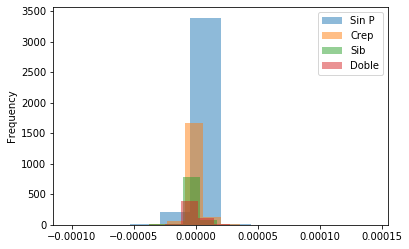

In [49]:
#Histogramas de la Suma de Promedios para cada uno de las categorías 

count,bin_edges = np.histogram(normal['Suma de Promedios']) 
normal['Suma de Promedios'].plot.hist(bins=bin_edges, alpha=0.5) 

count,bin_edges = np.histogram(crepitancia['Suma de Promedios']) 
crepitancia['Suma de Promedios'].plot.hist(bins=bin_edges, alpha=0.5) 

count,bin_edges = np.histogram(sibilancia['Suma de Promedios']) 
sibilancia['Suma de Promedios'].plot.hist(bins=bin_edges, alpha=0.5) 

count,bin_edges = np.histogram(dobles['Suma de Promedios']) 
dobles['Suma de Promedios'].plot.hist(bins=bin_edges, alpha=0.5) 

plt.legend(['Sin P', 'Crep', 'Sib', 'Doble'])

Se pudo observar que ninguno de los parámetros presenta una distribución normal, en único que sigue una distribución en forma de campana más no normal es la suma de los promedios, pero no cumple todas las carácterísticas principalmente porque la media no está alineada en el centro, además no hay igual probabilidad a lado y lado del cero, por lo tanto no cumple una distribución normal.

## Prueba de hipótesis

La prueba de hipótesisLas se utilizan para determinar si los valores obtenidos se deben al azar o sí son verdaderamente los valores del estudio. Para ello se plantean dos hipótesis, la hipótesis nula (HN) y la hipótesis alternativa (HA); si la prueba determina que el valor de p es menor que el alfa entonces se descarta la hipótesis nula y se reafirma la hipótesis alternativa, si no sucede lo contrario. 

Para la prueba de hipotesis se decidió usar la prueba de Mann-Whitney, puesto que se desea realizar un análisis no paramétrico debido a la distribución no normal de los parámetros a evaluar.
Debido a que se desea comparar 4 características (Sanos, Con Crepitancias, Con Sibilancias y con ambas patologías), el nivel de significancia alpha será de 0.013. El nivel de significancia usualmente se define con un valor de 0.05 (5%) para el análisis de dos características, pero debido a que se trabajará con cuatro características, se divide el alpha por el número de caracteríticas a analizar.



In [62]:
alpha=0.013 #0.05/4

##### Comparación de sujetos sanos y sujetos con crepitancias

HN: Los parámetros comparados de los ciclos respiratorios de sujetos sanos y de sujetos con crepitancias no muestran diferencias significativas. 

HA: Los parámetros comparados en los ciclos respiratorios de sujetos sanos y sujetos con crepitancias sí muestran diferencias significativas. 

In [69]:
#Se usa la función mannwhitneyu de la libreria Scipy para realizar la prueba de hipotesis entre los diferentes sujetos
#se compara cada una de las características de los diferentes sujetos

#Varianza

#mannwhitneyu recibe dos paramétros(x,y), los cuales son muestras de datos de una dimensión
# y retorna dos valores (statistics,pvalue)

statistics,pvalues = mannwhitneyu(normal['Varianza'],crepitancia['Varianza'])
print("Análisis de Varianza: ")
print(pvalues<alpha)
print ("Valor P: "+str(pvalues))

#Rango
statistics,pvalues = mannwhitneyu(normal['Rango'],crepitancia['Rango'])
print("\nAnálisis de Rango: ")
print(pvalues<alpha)
print ("Valor P: "+str(pvalues))

#Suma de Promedios
statistics,pvalues=mannwhitneyu(normal['Suma de Promedios'],crepitancia['Suma de Promedios'])
print("\nAnálisis de Suma de Promedios: ")
print(pvalues<alpha)
print ("Valor P: "+str(pvalues))

#Promedio de Espectros
statistics,pvalues=mannwhitneyu(normal['Promedio de Espectros'],crepitancia['Promedio de Espectros'])
print("\nAnálisis de Promedio de Espectros: ")
print(pvalues<alpha)
print ("Valor P: "+str(pvalues))

Análisis de Varianza: 
True
Valor P: 2.716365473498301e-41

Análisis de Rango: 
True
Valor P: 2.013649217242549e-62

Análisis de Suma de Promedios: 
False
Valor P: 0.07696345395222953

Análisis de Promedio de Espectros: 
True
Valor P: 2.713086916709796e-41


Tres de los cuatro parámetros evaluados mostraron diferencias significativas entre los sujetos sanos y con crepitancias, por lo tanto en el caso de la varianza, el rango y promedio espectral se cumple la HA. En el caso de la suma de promedio se reafirma la HN, esto quiere deir que el porcentaje de error es mayor y por lo tanto los valores encontrados pueden deberse a la casualidad. 

##### Comparación de sujetos sanos y sujetos con sibilancias

In [66]:
#Varianza
statistics,pvalues=mannwhitneyu(normal['Varianza'],sibilancia['Varianza'])
print("Análisis de Varianza: ")
print(pvalues<alpha)
print ("Valor P: "+str(pvalues))

#Rango
statistics,pvalues=mannwhitneyu(normal['Rango'],sibilancia['Rango'])
print("\nAnálisis de Rango: ")
print(pvalues<alpha)
print ("Valor P: "+str(pvalues))

#Suma de Promedios
statistics,pvalues=mannwhitneyu(normal['Suma de Promedios'],sibilancia['Suma de Promedios'])
print("\nAnálisis de Suma de Promedios: ")
print(pvalues<alpha)
print ("Valor P: "+str(pvalues))

#Promedio de Espectros
statistics,pvalues=mannwhitneyu(normal['Promedio de Espectros'],sibilancia['Promedio de Espectros'])
print("\nAnálisis de Promedio de Espectros: ")
print(pvalues<alpha)
print ("Valor P: "+str(pvalues))

Análisis de Varianza: 
True
Valor P: 6.086833272652355e-32

Análisis de Rango: 
True
Valor P: 3.4680229505874866e-24

Análisis de Suma de Promedios: 
False
Valor P: 0.06406871288440384

Análisis de Promedio de Espectros: 
True
Valor P: 6.080668149078669e-32


Tres de los cuatro parámetros evaluados mostraron diferencias significativas entre los sujetos sanos y con sibilancias, por lo tanto en el caso de la varianza, el rango y promedio espectral se cumple la HA. En el caso de la suma de promedio se reafirma la HN, esto quiere deir que el porcentaje de error es mayor y por lo tanto los valores encontrados pueden deberse a la casualidad. Es curioso que en ambos casos sibilancia y crepitancia se halla obtenido resultados similares, entonces se esperaría obtener lo mismo en el caso de la doble patología. 

##### Comparación de sujetos sanos y sujetos con doble patología

In [71]:
#Varianza
statistics,pvalues=mannwhitneyu(normal['Varianza'],dobles['Varianza'])
print("Análisis de Varianza: ")
print(pvalues<alpha)
print ("Valor P: "+str(pvalues))

#Rango
statistics,pvalues=mannwhitneyu(normal['Rango'],dobles['Rango'])
print("\nAnálisis de Rango: ")
print(pvalues<alpha)
print ("Valor P: "+str(pvalues))

#Suma de Promedios
statistics,pvalues=mannwhitneyu(normal['Suma de Promedios'],dobles['Suma de Promedios'])
print("\nAnálisis de Suma de Promedios: ")
print(pvalues<alpha)
print ("Valor P: "+str(pvalues))

#Promedio de Espectros
statistics,pvalues=mannwhitneyu(normal['Promedio de Espectros'],dobles['Promedio de Espectros'])
print("\nAnálisis de Promedio de Espectros: ")
print(pvalues<alpha)
print ("Valor P: "+str(pvalues))

Análisis de Varianza: 
True
Valor P: 8.315011961560036e-23

Análisis de Rango: 
True
Valor P: 7.540969227754743e-24

Análisis de Suma de Promedios: 
False
Valor P: 0.2579471598051376

Análisis de Promedio de Espectros: 
True
Valor P: 8.308517899984339e-23


Se puede observar que en este caso se cumple lo mismo que en los otros dos, por lo tanto podemos concluir que comparando los sujetos normales con los patológicos los valores de la varianza, rango y promedio de espectro sí son debido al estudio y no a la casualidad, contrario a lo que se puede afirma de la suma de promedio móviles. 

##### Comparación de sujetos con crepitancias y sujetos con sibilancias


In [68]:
#Varianza
statistics,pvalues=mannwhitneyu(crepitancia['Varianza'],sibilancia['Varianza'])
print("Análisis de Varianza: ")
print(pvalues<alpha)
print ("Valor P: "+str(pvalues))

#Rango
statistics,pvalues=mannwhitneyu(crepitancia['Rango'],sibilancia['Rango'])
print("\nAnálisis de Rango: ")
print(pvalues<alpha)
print ("Valor P: "+str(pvalues))

#Suma de Promedios
statistics,pvalues=mannwhitneyu(crepitancia['Suma de Promedios'],sibilancia['Suma de Promedios'])
print("\nAnálisis de Suma de Promedios: ")
print(pvalues<alpha)
print ("Valor P: "+str(pvalues))

#Promedio de Espectros
statistics,pvalues=mannwhitneyu(crepitancia['Promedio de Espectros'],sibilancia['Promedio de Espectros'])
print("\nAnálisis de Promedio de Espectros: ")
print(pvalues<alpha)
print ("Valor P: "+str(pvalues))

Análisis de Varianza: 
True
Valor P: 0.010570063291555009

Análisis de Rango: 
False
Valor P: 0.013719878141456334

Análisis de Suma de Promedios: 
False
Valor P: 0.41350049392460136

Análisis de Promedio de Espectros: 
True
Valor P: 0.01057437681617941


Se decidió realizar una comparación entre ambas patologías para determinar si existía una diferencia significativa, y efectivamente sí exite para el caso de la varianza y del promedio de espectro, pero sorpresivamente esto no se cumple en dos parámetrs que son el rango y la suma de promedios. Se cree que este resultado inesperado en el rango es debido a que no existe una diferencia significativa en la duración de los ciclos respiratorios entre las personas con patologías, y por tanto sus valores son muy parecidos y no es posible diferencia sólo con este parámetro las personas con sibilancias de las personas con crepitancias. 